In [2]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.utils import to_categorical
from skimage.transform import resize
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os
%matplotlib inline

Using TensorFlow backend.


In [3]:
DATA_LOCATION = '../data/'
TEST_IMAGES_LOCATION = '../data/test_images/'
IMAGE_SIZE = 64

filenames = [i for i in os.listdir('../data/test_images') if i.endswith('.jpg')]
labels = pd.DataFrame(filenames, columns=['filepath'])

In [4]:
def get_image(row):
    """
    Load image from filepath to a numpy.ndarray
    input:
        - filepath: string with relative or absolute path to image
    output:
        - img:
            numpy.ndarray containing the image
            shaped (M,N), values [0.0, 1.0]
    """
    try:
        img = TEST_IMAGES_LOCATION + row['filepath']
        try:
            img = mpimg.imread(img)
        except OSError:
            pass
    except:
        img = row
        img = mpimg.imread(img)
    try:
        img = np.absolute(np.divide(img.astype(float), 255) - 1.0)
    except AttributeError:
        pass
    return img

def get_padding(i):
    """
    Helper function for getting right padding sizes
    input:
        - i: positive integer gotten from substracting height and width of an image
    output:
        - Tuple representing the correct padding
    """
    if i%2 == 0:
        return (int(i/2),int(i/2))
    else:
        return (int(i/2-.5), int(i/2+.5))
    
def pad_image(img):
    """
    Add padding to image to make it square
    input:
        - img: numpy array (2D) representing image
    output:
        - padded array of shape (N,N)
    """
    H, W = img.shape
    if H == W:
        return img
    elif H > W:
        return np.pad(img, ((0,0), get_padding(H-W)), 'constant')
    else:
        return np.pad(img, (get_padding(W-H), (0,0)), 'constant')
    
def resize_image(img, size):
    """
    Resize image to new square shape
    input:
        - img: numpy array (2D) representing image
        - size: final shape of image in pixels (integer)
    """
    return resize(img, (size,size), mode='reflect')

def flattened_image(row):
    """
    Loads and processes image to be used later on
    input:
        - row: Pandas.DataFrame row
    output:
        - Python list, flattened np.ndarray
    """
    img = get_image(row)
    img = pad_image(img)
    img = resize_image(img, IMAGE_SIZE)
    return img.flatten().tolist()

def get_shape(row):
    """
    Loads and processes image to be used later on
    input:
        - row: Pandas.DataFrame row
    output:
        - tuple, with original image dimensions
    """
    img = get_image(row)
    return img.shape

In [5]:
labels.head()
labels['image'] = labels.apply(flattened_image, axis=1)

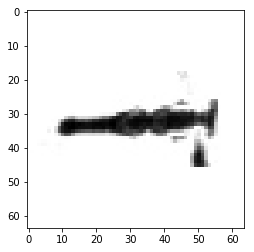

In [6]:
example = labels.iloc[0]
plt.imshow(np.asarray(example['image']).reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='binary')

In [7]:
test_data = labels['image'].values
test_labels = labels['filepath'].values

for i in range(len(test_data)):
    test_data[i] = np.asarray(test_data[i])

print('{}, {}'.format(test_data.shape, test_data[0].shape))
test_data = np.array(test_data.tolist())
print('{}'.format(test_data.shape))

(6132,), (4096,)
(6132, 4096)


In [8]:
test_data = np.reshape(test_data, (-1,64,64,1))
print('{}'.format(test_data.shape))

(6132, 64, 64, 1)


In [9]:
model = load_model('../data/output/models/model5.h5')

In [10]:
model.predict_classes(test_data[[0],:], verbose=0)[0]


67

In [11]:
test_data[[0]].shape

(1, 64, 64, 1)

In [11]:
def predict(array):
    return model.predict_classes(array, verbose=0)[0]

In [12]:
predictions = [(test_labels[i], predict(test_data[[i]])) for i in range(len(test_data))]

In [13]:
predictions = dict(predictions)
list(predictions.items())[:5]

df = pd.DataFrame(list(predictions.items()), columns = ['image', 'class'], index=range(len(predictions)))

In [14]:
df.sort_values(by='image')

,image,class
0,100065.jpg,67
1,100070.jpg,28
2,100094.jpg,70
3,100115.jpg,34
4,100181.jpg,45
5,10019.jpg,34
6,100196.jpg,8
7,100219.jpg,21
8,100238.jpg,58
9,100248.jpg,5


In [15]:
len(predictions)

6132

In [16]:
df.to_csv('../data/output/predictions/model5.csv', index=False)